In [ ]:
import os

import pandas as pd

from nlp import pipeline_d2v, pipeline_lda
from processors import QueProc, StuProc, ProProc
from generator import BatchGenerator
from models import DistanceModel, SimpleModel, ConcatModel, Adam
from evaluation import permutation_importance, plot_fi
from utils import TextProcessor

pd.set_option('display.max_columns', 100, 'display.width', 1024)
pd.options.mode.chained_assignment = None

DATA_PATH, SPLIT_DATE = '../../data/', '2019-01-01'

tp = TextProcessor()

# READ

In [ ]:
ans = pd.read_csv(os.path.join(DATA_PATH, 'answers.csv'), parse_dates=['answers_date_added'])
ans['answers_body'] = ans['answers_body'].apply(tp.process)
ans_train = ans[ans['answers_date_added'] < SPLIT_DATE]

que = pd.read_csv(os.path.join(DATA_PATH, 'questions.csv'), parse_dates=['questions_date_added'])
que['questions_title'] = que['questions_title'].apply(tp.process)
que['questions_body'] = que['questions_body'].apply(tp.process)
que_train = que[que['questions_date_added'] < SPLIT_DATE]

pro = pd.read_csv(os.path.join(DATA_PATH, 'professionals.csv'), parse_dates=['professionals_date_joined'])
pro['professionals_headline'] = pro['professionals_headline'].apply(tp.process)
pro['professionals_industry'] = pro['professionals_industry'].apply(tp.process)
pro_train = pro[pro['professionals_date_joined'] < SPLIT_DATE]

stu = pd.read_csv(os.path.join(DATA_PATH, 'students.csv'), parse_dates=['students_date_joined'])
stu_train = stu[stu['students_date_joined'] < SPLIT_DATE]

tags = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv'))
tags['tags_tag_name'] = tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))

tag_que = pd.read_csv(os.path.join(DATA_PATH, 'tag_questions.csv')) \
    .merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tag_users = pd.read_csv(os.path.join(DATA_PATH, 'tag_users.csv')) \
    .merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

# ADDITIONAL

In [ ]:
# mappings from question's id to its author id. Used in Predictor
que_to_stu = {row['questions_id']: row['questions_author_id'] for i, row in que.iterrows()}

# mappings from professional's id to his registration date. Used in batch generator
pro_to_date = {row['professionals_id']: row['professionals_date_joined'] for i, row in pro.iterrows()}

# construct dataframe used to extract positive pairs
pairs_df = que.merge(ans, left_on='questions_id', right_on='answers_question_id') \
    .merge(pro, left_on='answers_author_id', right_on='professionals_id') \
    .merge(stu, left_on='questions_author_id', right_on='students_id')

pairs_df = pairs_df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

# TRAIN

In [ ]:
# calculate and save tag and industry embeddings on train data
tag_embs, ind_embs, ques_d2v = pipeline_d2v(que_train, ans_train, pro_train, tag_que, 10)

In [ ]:
lda_dic, lda_tfidf, lda_model = pipeline_lda(que_train, tag_que, 10)

In [34]:
# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] < SPLIT_DATE].itertuples(index=False, name=None))

# extract and preprocess feature for all three main entities

que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(que_train, tag_que)

stu_proc = StuProc()
stu_data = stu_proc.transform(stu_train, que_train, ans_train)

pro_proc = ProProc(tag_embs, ind_embs)
pro_data = pro_proc.transform(pro_train, que_train, ans_train, tag_users)

bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, pos_pairs, pro_to_date)

# MODEL

In [36]:
# in train mode, build, compile train and save model
model = DistanceModel(que_dim=len(que_data.columns) - 2 + len(stu_data.columns) - 2,
                      que_input_embs=[102, 42], que_output_embs=[2, 2],
                      pro_dim=len(pro_data.columns) - 2,
                      pro_input_embs=[102, 102, 42], pro_output_embs=[2, 2, 2],
                      inter_dim=20, output_dim=10)

model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(bg, epochs=5, verbose=2)

model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(bg, epochs=10, verbose=2)

Epoch 1/5
 - 11s - loss: 0.6267 - acc: 0.6717
Epoch 2/5
 - 9s - loss: 0.5881 - acc: 0.6966
Epoch 3/5
 - 11s - loss: 0.5833 - acc: 0.7007
Epoch 4/5
 - 11s - loss: 0.5813 - acc: 0.7014
Epoch 5/5
 - 10s - loss: 0.5790 - acc: 0.7038
Epoch 1/10
 - 12s - loss: 0.5496 - acc: 0.7271
Epoch 2/10
 - 12s - loss: 0.5443 - acc: 0.7323
Epoch 3/10
 - 9s - loss: 0.5416 - acc: 0.7347
Epoch 4/10
 - 10s - loss: 0.5402 - acc: 0.7371
Epoch 5/10
 - 10s - loss: 0.5380 - acc: 0.7375
Epoch 6/10
 - 10s - loss: 0.5351 - acc: 0.7406
Epoch 7/10
 - 10s - loss: 0.5361 - acc: 0.7395
Epoch 8/10
 - 8s - loss: 0.5347 - acc: 0.7416
Epoch 9/10
 - 10s - loss: 0.5331 - acc: 0.7402
Epoch 10/10
 - 10s - loss: 0.5311 - acc: 0.7438


# EVALUATION

2048/2048 [==============================] - ETA: 15 - ETA: 0 - ETA:  - ETA:  - 0s 207us/step


Feature importance: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:46<00:00,  1.65it/s]


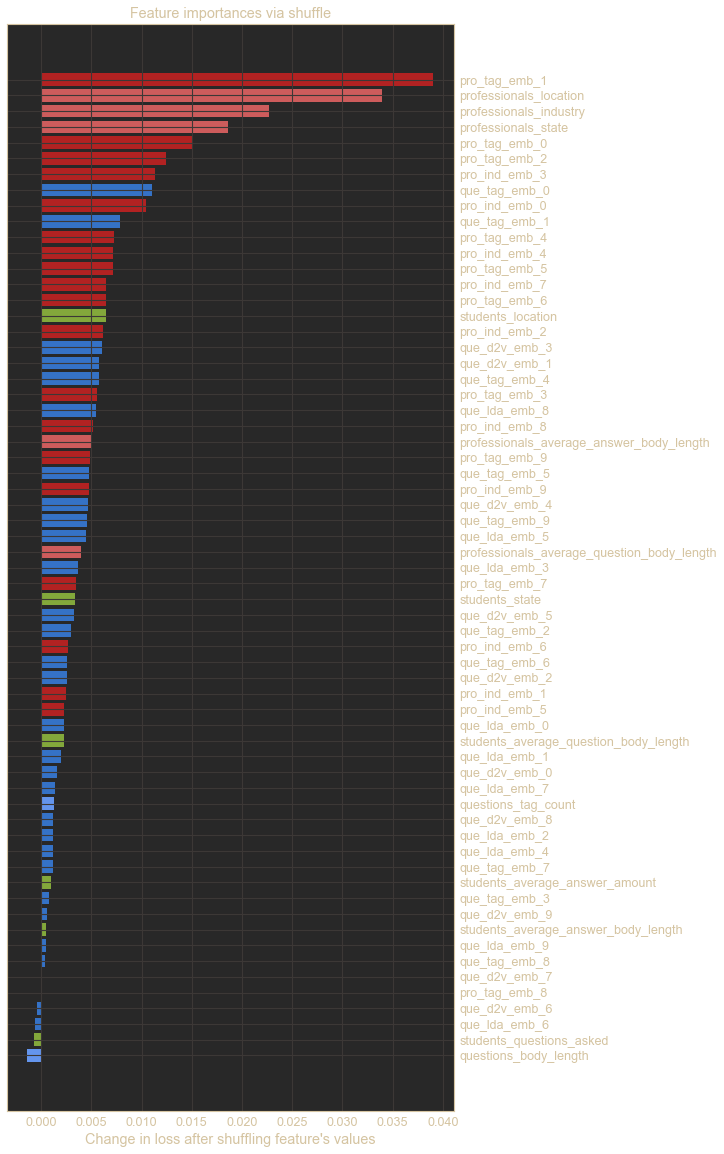

In [37]:
# dummy batch generator used to extract single big batch of data to calculate feature importance
bg = BatchGenerator(que_data, stu_data, pro_data, 1024, pos_pairs, pos_pairs, pro_to_date)

# dict with descriptions of feature names, used for visualization of feature importance
fn = {"que": list(stu_data.columns[2:]) + list(que_data.columns[2:]),
      "pro": list(pro_data.columns[2:])}

# calculate and plot feature importance
fi = permutation_importance(model, bg[0][0][0], bg[0][0][1], bg[0][1], fn, n_trials=3)
plot_fi(fi)

# TEST

In [38]:
# non-negative pairs are all known positive pairs to the moment
nonneg_pairs = pos_pairs

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] >= SPLIT_DATE].itertuples(index=False, name=None))
nonneg_pairs += pos_pairs

# extract and preprocess feature for all three main entities

que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(que, tag_que)

stu_proc = StuProc()
stu_data = stu_proc.transform(stu, que, ans)

pro_proc = ProProc(tag_embs, ind_embs)
pro_data = pro_proc.transform(pro, que, ans, tag_users)

bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, nonneg_pairs, pro_to_date)

# EVALUATION

Loss: 0.550431469312081, accuracy: 0.7295673076923077
1682/1682 [==============================] - ETA:  - ETA:  - ETA:  - 0s 79us/step


Feature importance: 100%|██████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.71it/s]


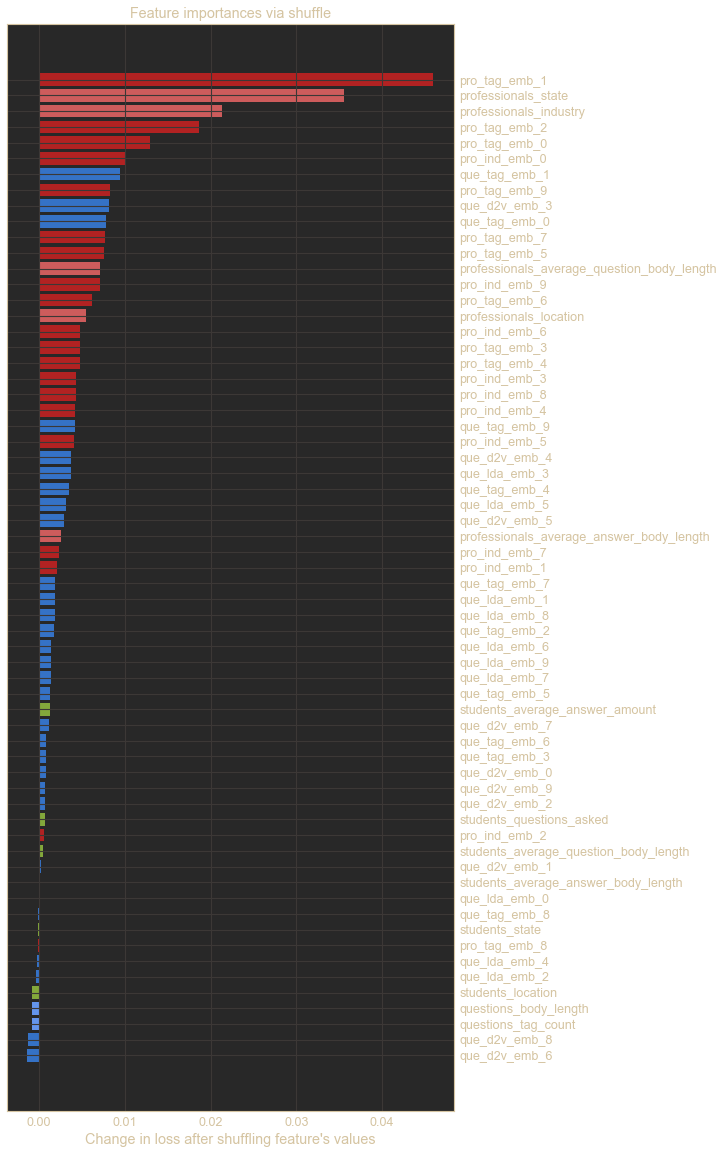

In [39]:
loss, acc = model.evaluate_generator(bg)
print(f'Loss: {loss}, accuracy: {acc}')

# dummy batch generator used to extract single big batch of data to calculate feature importance
bg = BatchGenerator(que_data, stu_data, pro_data, 1024, pos_pairs, nonneg_pairs, pro_to_date)

# dict with descriptions of feature names, used for visualization of feature importance
fn = {"que": list(stu_data.columns[2:]) + list(que_data.columns[2:]),
      "pro": list(pro_data.columns[2:])}

# calculate and plot feature importance
fi = permutation_importance(model, bg[0][0][0], bg[0][0][1], bg[0][1], fn, n_trials=3)
plot_fi(fi)

# PREDICTIONS

In [40]:
import predictor

In [41]:
pred = predictor.Predictor(model, que_data, stu_data, pro_data, que_to_stu, que_proc, pro_proc)

In [42]:
formatter = predictor.Formatter('../../data/')

# From ques

In [52]:
que_sample_dict = {
    'questions_id': ['332a511f1569444485cf7a7a556a5e54'],
    'questions_author_id': ['8f6f374ffd834d258ab69d376dd998f5'],
    'questions_date_added': ['2016-04-26 11:14:26'],
    'questions_title': ['Teacher   career   question'],
    'questions_body': ['What  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecture'],
    'questions_tags': ['college lecture professor']
}

In [53]:
que_sample_df, que_sample_tags = predictor.Formatter.convert_que_dict(que_sample_dict)

In [54]:
tmp = pred.find_pros_by_que(que_sample_df, que_sample_tags)
formatter.get_pro(tmp)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,tags_tag_name,id,match_id,match_score
2,fe40a0bcb4ad4f819d308bb1c91ec221,"Bengaluru, Karnataka, India",NaN,DELL,2016-04-28 22:00:07 UTC+0000,education,332a511f1569444485cf7a7a556a5e54,fe40a0bcb4ad4f819d308bb1c91ec221,0.739378
6,ad741868a4494cf4852e40afb02d7956,"Bengaluru, Karnataka, India",NaN,NaN,2016-05-26 23:30:04 UTC+0000,education,332a511f1569444485cf7a7a556a5e54,ad741868a4494cf4852e40afb02d7956,0.728449
1,c39329e6c790449f812590c3b897aca8,"Bengaluru, Karnataka, India",Support,Technical Support Specialist at Dell,2016-04-27 20:53:04 UTC+0000,medicine,332a511f1569444485cf7a7a556a5e54,c39329e6c790449f812590c3b897aca8,0.712931
0,f155d857bc4d4295af7985fc375c2b19,"Iowa City, Iowa",Education Sales/Training,Science Specialist at Pearson and Former Educa...,2015-11-18 13:50:10 UTC+0000,stem education-management education-profession...,332a511f1569444485cf7a7a556a5e54,f155d857bc4d4295af7985fc375c2b19,0.711592
7,97ac539abf554ca399f1075b0818dc75,"Hyderabad, Telangana, India",Information Technology and Services,Software Dev Analyst at Dell,2016-06-09 17:51:00 UTC+0000,education information-technology,332a511f1569444485cf7a7a556a5e54,97ac539abf554ca399f1075b0818dc75,0.707530
5,7385c14f6f1d42678c3b4be9df5642fb,"Hyderabad, Telangana, India",Information Technology and Services,Business Systems Sr. Advisor at Dell,2016-05-23 14:35:43 UTC+0000,information-technology analyst,332a511f1569444485cf7a7a556a5e54,7385c14f6f1d42678c3b4be9df5642fb,0.698868
8,6a388a0aecba4e25a7c06cb389577386,"Bengaluru, Karnataka, India",NaN,Author,2018-03-09 21:24:40 UTC+0000,teacher counselling k-12-education life-scienc...,332a511f1569444485cf7a7a556a5e54,6a388a0aecba4e25a7c06cb389577386,0.698855
4,28b1b04a71b8436da36b1d54d9ffea70,"Hyderabad, Telangana, India",NaN,Share Happiness!,2016-05-16 20:06:02 UTC+0000,counselling child-care data-entry,332a511f1569444485cf7a7a556a5e54,28b1b04a71b8436da36b1d54d9ffea70,0.698355
9,578f41bd85da4811bc1a677e70e9ae39,"Los Angeles, California",Information Technology and Services,Client Onsite Systems Engineering (OSE) at Dell,2018-10-01 20:03:25 UTC+0000,information-technology-and-services,332a511f1569444485cf7a7a556a5e54,578f41bd85da4811bc1a677e70e9ae39,0.692375
3,fe5fc534894e45c191e87f8c2ea0c6bd,"Bengaluru, Karnataka, India",NaN,Tech-RSM,2016-04-29 23:51:33 UTC+0000,science education math technical-support,332a511f1569444485cf7a7a556a5e54,fe5fc534894e45c191e87f8c2ea0c6bd,0.689774


In [62]:
tmp = pred.find_ques_by_que(que_sample_df, que_sample_tags)
formatter.get_que(tmp)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
4,33507de75ab14ccca8d43770f510ebe6,2eb808eafcb1415b828f001df0d09942,2016-05-27 10:46:49 UTC+0000,HOW CAN I BECOME A LECTURER AFTER MY POST GRAD...,MY PASSION IS TEACHING I WANT TO INVOLVE WITH...,professors,332a511f1569444485cf7a7a556a5e54,33507de75ab14ccca8d43770f510ebe6,0.878683
7,5879cb1d231c4481bb096f3d44aa4f4e,931f3f7ab17b486abebda6a941d75f05,2016-05-21 06:01:47 UTC+0000,after 10th which course is best?,for my education. #educator,educator,332a511f1569444485cf7a7a556a5e54,5879cb1d231c4481bb096f3d44aa4f4e,0.870567
9,2f985653a39043ccbd6256b49bedd3b3,02fbe31646734140ab5365ddd018954e,2016-05-21 05:50:43 UTC+0000,Why should I study?,I am not interested. #educator,educator,332a511f1569444485cf7a7a556a5e54,2f985653a39043ccbd6256b49bedd3b3,0.865235
8,4437f2bedd124207aeed5a4264c99e00,833c9dab676c4d07a5e7734de619366f,2016-05-18 09:05:29 UTC+0000,i want to do I T I,i want to do I T I when what I want to red #ed...,educators,332a511f1569444485cf7a7a556a5e54,4437f2bedd124207aeed5a4264c99e00,0.862718
2,90158e5f27634b22b6a47aa11022823c,8b482f833a1b4f8fbcad119644d0455d,2016-06-22 10:01:18 UTC+0000,is the teaching profession good?,"want to become a teacher, this profession is g...",teacher professional lecture,332a511f1569444485cf7a7a556a5e54,90158e5f27634b22b6a47aa11022823c,0.861638
5,e2320824779d4a28926ecaa61a181a4e,b0650c915d0246c0b55c5c6cbfdbb8b8,2016-05-07 07:07:32 UTC+0000,how to control the mouth cancer,hi i am sowmiya .i am studing 10 std .i want t...,doctor science teacher professor,332a511f1569444485cf7a7a556a5e54,e2320824779d4a28926ecaa61a181a4e,0.859097
3,592426c5c0a84e66a1f991269170c747,3b0e10eb04d54368861e0046329bd997,2016-06-22 11:31:55 UTC+0000,how to make a robot,i don't know to make a robot #teacher,teacher,332a511f1569444485cf7a7a556a5e54,592426c5c0a84e66a1f991269170c747,0.858976
6,7c868e245b534beca02394bde4c142a1,f0ceb75ce4c240389d329c4d99ecfe2e,2016-05-05 10:50:30 UTC+0000,how do I become a mathematician?,"mathematician, scientist, professor #college #...",college teacher professor higher-education,332a511f1569444485cf7a7a556a5e54,7c868e245b534beca02394bde4c142a1,0.858518
1,570d6badc726461a8721701869e99c35,5bf0fb91ff5343ccbe6d5afd2c84a1ae,2016-05-26 10:29:04 UTC+0000,i want to become teacher ?,in future what course i should take to become ...,teacher,332a511f1569444485cf7a7a556a5e54,570d6badc726461a8721701869e99c35,0.857876
0,c2c7b2a54fb54b5c849c98f6d52e1bc2,e48b82b5b2ec41e3aba9a7a5f5e452c6,2016-05-10 10:12:10 UTC+0000,"I want to become a lecturer, what courses shou...",I recently completed my 10th standard. #profes...,college career professor education school high...,332a511f1569444485cf7a7a556a5e54,c2c7b2a54fb54b5c849c98f6d52e1bc2,0.848962


# From pros

In [63]:
pro_sample_dict = {
    'professionals_id': ['f64df9b489864952917cb631be1ddac7'],
    'professionals_location': ['United States'],
    'professionals_industry': ['Telecommunications'],
    'professionals_headline': ['Wireless Technology Planning'],
    'professionals_date_joined': ['2016-11-28 20:24:01'],
    'professionals_subscribed_tags': ['pharmaceutical-industry medicine healthcare-it biology science healthcare research']
}

In [64]:
pro_sample_df, pro_sample_tags = predictor.Formatter.convert_pro_dict(pro_sample_dict)

In [65]:
ans_raw_df = pd.read_csv('../../data/answers.csv')
que_raw_df = pd.read_csv('../../data/questions.csv')

In [66]:
tmp = pred.find_ques_by_pro(pro_sample_df, que_raw_df, ans_raw_df, pro_sample_tags)
formatter.get_que(tmp)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,tags_tag_name,id,match_id,match_score
7,c2b40f9d4aac479f80e06218656f5013,01ec1b9093f64d67816ef5d652d6aa13,2016-05-24 22:14:35 UTC+0000,What is a typical day like in biochemistry res...,I really don't know what a typical day would l...,research bio-chem,f64df9b489864952917cb631be1ddac7,c2b40f9d4aac479f80e06218656f5013,0.826206
4,e61af9de75b64c81a7a9744b19289a11,bf5bf9f7c22e4c03a6d968a07f046362,2016-10-20 22:36:35 UTC+0000,How flexible are career choices if I have a de...,I am certain that Imwould like to enter a care...,biology stem biotechnology biochemistry molecu...,f64df9b489864952917cb631be1ddac7,e61af9de75b64c81a7a9744b19289a11,0.801885
1,7a168db453d94a0a9b79e2d5550a9568,bfdc832304594082b52140989f6bddab,2017-01-03 08:53:47 UTC+0000,Am I able to get my PhD in anything?,I wanted to do psychology but my mom and frien...,engineering psychology college-majors phd,f64df9b489864952917cb631be1ddac7,7a168db453d94a0a9b79e2d5550a9568,0.780051
2,cfb4970fc5394c70a9e4ab736f53a5a0,ea77cfe38f1e4439b0b112e096847c1e,2016-11-02 18:46:52 UTC+0000,How would I go about getting an entry level cl...,I am looking for an entry level research posit...,medicine medical research medical-school medic...,f64df9b489864952917cb631be1ddac7,cfb4970fc5394c70a9e4ab736f53a5a0,0.773183
6,fc3ae330c1b34dff8ae61cbff6f75886,2c8eab0e4ee34154bdc0a2a71dcfbb9a,2017-03-07 04:24:31 UTC+0000,"As a chemistry major, what are some gen ed cla...","I am a chemistry major, and I am working on my...",science career-counseling chemistry scheduling...,f64df9b489864952917cb631be1ddac7,fc3ae330c1b34dff8ae61cbff6f75886,0.768028
8,31742df364524821be538689ccae0e3a,7cc2f0f7bbd647d8babd97ff18636bda,2016-05-20 17:16:20 UTC+0000,What is the most useful thing to minor in duri...,The job out look for genetic counselors has li...,counselor scientist doctorate-degree genetics,f64df9b489864952917cb631be1ddac7,31742df364524821be538689ccae0e3a,0.760309
0,865a21939b364ba2822a83070f25a17b,0690f54244414964aaff95736cd66162,2015-03-19 19:22:15 UTC+0000,What type of innovative inventions have been m...,I'm really interested in Biology and have back...,engineer biology molecular-biology biotech,f64df9b489864952917cb631be1ddac7,865a21939b364ba2822a83070f25a17b,0.758087
5,1d4af1ef8d8048b78ce7b793f605cd15,87b5245bcfe8482b97b6c2deb1b65e22,2016-05-23 02:59:25 UTC+0000,What can i do with a degree in chemistry?,I enjoy chemistry and would like to make a car...,chemistry bio-chem chemist,f64df9b489864952917cb631be1ddac7,1d4af1ef8d8048b78ce7b793f605cd15,0.751956
9,98afdcb5e46d4336b55e37f34c9ab6be,9f9c121957074f6dbc58bcf4cef44a74,2016-10-31 15:05:04 UTC+0000,"What boundaries, if any, can limit a Research ...",I would like to know how successful I can expe...,science research biochemistry laboratory,f64df9b489864952917cb631be1ddac7,98afdcb5e46d4336b55e37f34c9ab6be,0.746118
3,986918316d7b47688b0a03330a36b5b4,65eb3a9ed2cc4e3aaf239c0670575f17,2016-10-22 19:16:41 UTC+0000,"For a career in genetics research, what kind o...",I am hoping to be a researcher in the field of...,medicine science biology,f64df9b489864952917cb631be1ddac7,986918316d7b47688b0a03330a36b5b4,0.744860


In [67]:
tmp = pred.find_pros_by_pro(pro_sample_df, que_raw_df, ans_raw_df, pro_sample_tags, 10)
formatter.get_pro(tmp)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,tags_tag_name,id,match_id,match_score
6,54977979de3345f1a3021236d2f95695,"Baltimore, Maryland Area",Agriculture,--,2018-07-31 14:58:09 UTC+0000,research,f64df9b489864952917cb631be1ddac7,54977979de3345f1a3021236d2f95695,0.809216
1,6e61cd72d1444a4f8c217b55883480e1,"Indiana, Indiana","Research, remediation",Environmental Scientist at AECOM,2017-04-18 15:10:41 UTC+0000,research groundwater-remediation remediation,f64df9b489864952917cb631be1ddac7,6e61cd72d1444a4f8c217b55883480e1,0.796124
7,060606aac928478bb56a0ef76e8ba4d7,NaN,Biotechnology,R&D Engineer at Abbott Labboratories,2018-09-23 01:59:36 UTC+0000,biotechnology,f64df9b489864952917cb631be1ddac7,060606aac928478bb56a0ef76e8ba4d7,0.790807
2,325d36c002ca4661bbe1d90817252eaa,San Francisco Bay Area,Biotechnology,Biologist,2017-07-07 19:32:47 UTC+0000,biotechnology pr bio mol prot,f64df9b489864952917cb631be1ddac7,325d36c002ca4661bbe1d90817252eaa,0.788685
4,8d48ab9288b1467e9b9d86aa9588eb37,"Houston, Texas Area",Biotechnology,Molecular biologist,2017-10-23 13:14:43 UTC+0000,biotechnology,f64df9b489864952917cb631be1ddac7,8d48ab9288b1467e9b9d86aa9588eb37,0.784842
0,41d28ab2ad464f2b996625af681afe7c,"San Antonio, Texas",Biomedical research,Biomedical scientist,2017-01-19 19:15:25 UTC+0000,research,f64df9b489864952917cb631be1ddac7,41d28ab2ad464f2b996625af681afe7c,0.772966
3,c285b983f2bd4893ab9c5b25930a82c9,"Indianapolis, Indiana Area",Biotechnology,"Bioprocess Development Scientist at Algaeon, Inc.",2017-09-12 22:33:23 UTC+0000,biology biotechnology molecular-biology geneti...,f64df9b489864952917cb631be1ddac7,c285b983f2bd4893ab9c5b25930a82c9,0.768772
8,f3b499adc6154ec9b8371fe18671c0f8,"San Diego, California",Biotechnology,"Senior Manager, Research & Development at Ther...",2018-10-27 23:03:04 UTC+0000,college college-major biology research biotech...,f64df9b489864952917cb631be1ddac7,f3b499adc6154ec9b8371fe18671c0f8,0.768354
9,808e40e4275246deb4bcff63c4c17fc7,"Naples Area, Italy",Biotechnology,"Biologist, Yoga guru, musician",2018-10-28 07:52:35 UTC+0000,biotechnology,f64df9b489864952917cb631be1ddac7,808e40e4275246deb4bcff63c4c17fc7,0.762866
5,bb853437d84a447b9dd7bb7a9336d57f,"El Paso, Texas Area",Biotechnology,Ph.D. in Materials Science and Engineering,2018-06-20 15:34:31 UTC+0000,biotechnology,f64df9b489864952917cb631be1ddac7,bb853437d84a447b9dd7bb7a9336d57f,0.761311
